In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import lightgbm
import shap
import itertools
pd.options.mode.chained_assignment = None

os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.data.gw_features import add_gw_features
from src.features.custom_transformers import TimeSeriesFeatures

%matplotlib inline
pd.set_option('display.max_columns', None)
DATA_PATH = 'data/processed/'

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_all_seasons.parquet')
print(fpl_data_all_seasons.shape)
fpl_data_all_seasons.head()

(67320, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [3]:
id_details = fpl_data_all_seasons.groupby(['name', 'season', 'ID']).count().reset_index()[['name', 'season', 'ID']]

In [4]:
season_16_17 = fpl_data_all_seasons[fpl_data_all_seasons['season'] == '2016-17']
season_16_17.drop(
    ['name', 'season', 'team_name', 'team_name_opponent'],
    axis=1,
    inplace=True
)
season_16_17.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [5]:
static_features = [
    'was_home',
    'gw',
    'promoted_side',
    'top_6_last_season',
    'ID',
    'position_DEF',
    'position_FWD',
    'position_GK',
    'position_MID',
    'promoted_side_opponent', 'top_6_last_season_opponent',
    'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec', 'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 'kickoff_month_Sep',
    'late_kickoff',
    'early_kickoff'
]
ts_features = set(season_16_17.columns) - set(static_features)

In [6]:
gen_ts_features = TimeSeriesFeatures(halflife=4, max_lag=2, max_diff=2, columns=ts_features)

In [7]:
%%time
season_16_17_plus = gen_ts_features.fit_transform(season_16_17)

CPU times: user 44.6 s, sys: 8.88 s, total: 53.5 s
Wall time: 36.1 s


In [8]:
season_16_17_plus.shape

(23457, 253)

In [9]:
lgbm_model = lightgbm.LGBMRegressor()

In [10]:
%%time
lgbm_model.fit(season_16_17_plus, season_16_17['total_points'])

CPU times: user 14.2 s, sys: 412 ms, total: 14.6 s
Wall time: 4.52 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
predictions = lgbm_model.predict(season_16_17_plus)
mean_squared_error(season_16_17['total_points'], predictions)

2.441244021573803

In [17]:
season_16_17_plus['predictions'] = predictions
season_16_17_plus['total_points'] = season_16_17['total_points']

In [18]:
for gw in range(1,39):
    print(gw)
    subset = season_16_17_plus[season_16_17_plus['gw'] == gw]
    mse = mean_squared_error(subset['total_points'], subset['predictions'])
    print(mse)

1
4.548494883133864
2
2.9595814391680455
3
2.1802043518827143
4
2.812169992931214
5
2.935639223706797
6
2.651280308182784
7
1.7756052822833928
8
2.426415859718778
9
2.444499790345128
10
2.755640438811216
11
2.770398857388906
12
2.571993231952428
13
2.0328779503679595
14
2.9085866878376554
15
2.5722259669987957
16
2.2232490288884454
17
2.236821051670928
18
2.247228914244257
19
2.6115410419856127
20
2.603079459011799
21
2.942463484258688
22
1.9700599748391245
23
2.3693316702355203
24
2.708826814046761
25
2.3124906462077983
26
1.5974854643100382
27
2.115652468313828
28
2.3791934327056334
29
2.1460655905075465
30
2.3782985940732906
31
1.903493883741074
32
2.525884368181296
33
2.172261587547207
34
2.414679966512981
35
1.72012065545823
36
2.391045896939687
37
2.484729060545516
38
2.3851880765622293


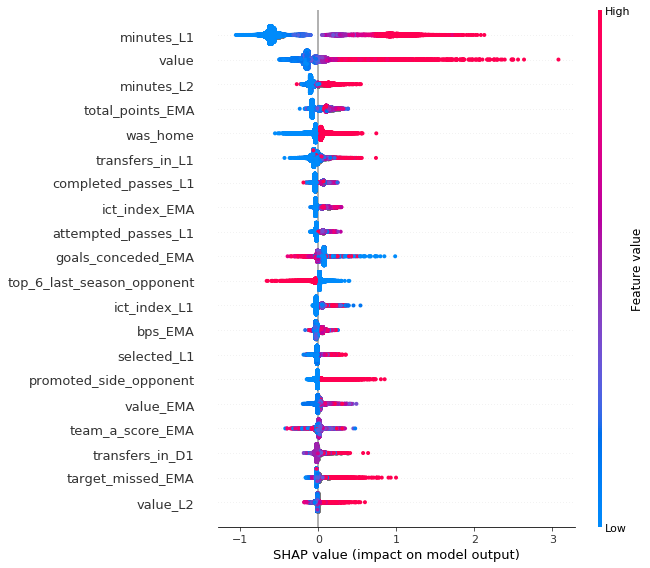

In [29]:
# LightGBM shap
shap_values = shap.TreeExplainer(lgbm_model).shap_values(season_16_17_plus)
shap.summary_plot(shap_values, season_16_17_plus)

In [33]:
season_16_17_plus['predictions'] = predictions
season_16_17_plus['total_points'] = season_16_17.copy()['total_points']

In [31]:
season_16_17_plus.head()

,value,was_home,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_D1,penalties_saved_D2,minutes_EMA,minutes_L1,minutes_L2,minutes_D1,minutes_D2,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_D1,loaned_in_D2,selected_EMA,selected_L1,selected_L2,selected_D1,selected_D2,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_D1,transfers_balance_D2,attempted_passes_EMA,attempted_passes_L1,attempted_passes_L2,attempted_passes_D1,attempted_passes_D2,bps_EMA,bps_L1,bps_L2,bps_D1,bps_D2,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_D1,goals_scored_D2,penalties_conceded_EMA,penalties_conceded_L1,penalties_conceded_L2,penalties_conceded_D1,penalties_conceded_D2,value_EMA,value_L1,value_L2,value_D1,value_D2,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_D1,red_cards_D2,total_points_EMA,total_points_L1,total_points_L2,total_points_D1,total_points_D2,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_D1,yellow_cards_D2,bonus_EMA,bonus_L1,bonus_L2,bonus_D1,bonus_D2,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_D1,transfers_out_D2,influence_EMA,influence_L1,influence_L2,influence_D1,influence_D2,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_D1,key_passes_D2,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_D1,goals_conceded_D2,threat_EMA,threat_L1,threat_L2,threat_D1,threat_D2,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_D1,penalties_missed_D2,big_chances_created_EMA,big_chances_created_L1,big_chances_created_L2,big_chances_created_D1,big_chances_created_D2,tackles_EMA,tackles_L1,tackles_L2,tackles_D1,tackles_D2,assists_EMA,assists_L1,assists_L2,assists_D1,assists_D2,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_D1,loaned_out_D2,open_play_crosses_EMA,open_play_crosses_L1,open_play_crosses_L2,open_play_crosses_D1,open_play_crosses_D2,saves_EMA,saves_L1,saves_L2,saves_D1,saves_D2,offside_EMA,offside_L1,offside_L2,offside_D1,offside_D2,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_D1,clean_sheets_D2,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_D1,big_chances_missed_D2,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_D1,own_goals_D2,ea_index_EMA,ea_index_L1,ea_index_L2,ea_index_D1,ea_index_D2,recoveries_EMA,recoveries_L1,recoveries_L2,recoveries_D1,recoveries_D2,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_D1,transfers_in_D2,fouls_EMA,fouls_L1,fouls_L2,fouls_D1,fouls_D2,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_D1,team_a_score_D2,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_D1,team_h_score_D2,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_D1,dribbles_D2,creativity_EMA,creativity_L1,creativity_L2,creativity_D1,creativity_D2,tackled_EMA,tackled_L1,tackled_L2,tackled_D1,tackled_D2,winning_goals_EMA,winning_goals_L1,winning_goals_L2,winning_goals_D1,winning_goals_D2,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,completed_passes_EMA,completed_passes_L1,completed_passes_L2,completed_passes_D1,completed_passes_D2,errors_leading_to_goal_EMA,errors_leading_to_goal_L1,errors_leading_to_goal_L2,errors_leading_to_goal_D1,errors_leading_to_goal_D2,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_D1,ict_index_D2,target_missed_EMA,target_missed_L1,t

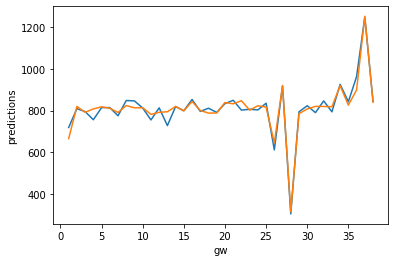

In [37]:
plot_df = season_16_17_plus.groupby('gw').sum()[['total_points', 'predictions']].reset_index()
sns.lineplot(plot_df['gw'], plot_df['total_points'])
sns.lineplot(plot_df['gw'], plot_df['predictions'])

In [49]:
season_16_17_plus.head()

,value,was_home,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_D1,penalties_saved_D2,minutes_EMA,minutes_L1,minutes_L2,minutes_D1,minutes_D2,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_D1,loaned_in_D2,selected_EMA,selected_L1,selected_L2,selected_D1,selected_D2,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_D1,transfers_balance_D2,attempted_passes_EMA,attempted_passes_L1,attempted_passes_L2,attempted_passes_D1,attempted_passes_D2,bps_EMA,bps_L1,bps_L2,bps_D1,bps_D2,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_D1,goals_scored_D2,penalties_conceded_EMA,penalties_conceded_L1,penalties_conceded_L2,penalties_conceded_D1,penalties_conceded_D2,value_EMA,value_L1,value_L2,value_D1,value_D2,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_D1,red_cards_D2,total_points_EMA,total_points_L1,total_points_L2,total_points_D1,total_points_D2,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_D1,yellow_cards_D2,bonus_EMA,bonus_L1,bonus_L2,bonus_D1,bonus_D2,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_D1,transfers_out_D2,influence_EMA,influence_L1,influence_L2,influence_D1,influence_D2,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_D1,key_passes_D2,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_D1,goals_conceded_D2,threat_EMA,threat_L1,threat_L2,threat_D1,threat_D2,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_D1,penalties_missed_D2,big_chances_created_EMA,big_chances_created_L1,big_chances_created_L2,big_chances_created_D1,big_chances_created_D2,tackles_EMA,tackles_L1,tackles_L2,tackles_D1,tackles_D2,assists_EMA,assists_L1,assists_L2,assists_D1,assists_D2,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_D1,loaned_out_D2,open_play_crosses_EMA,open_play_crosses_L1,open_play_crosses_L2,open_play_crosses_D1,open_play_crosses_D2,saves_EMA,saves_L1,saves_L2,saves_D1,saves_D2,offside_EMA,offside_L1,offside_L2,offside_D1,offside_D2,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_D1,clean_sheets_D2,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_D1,big_chances_missed_D2,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_D1,own_goals_D2,ea_index_EMA,ea_index_L1,ea_index_L2,ea_index_D1,ea_index_D2,recoveries_EMA,recoveries_L1,recoveries_L2,recoveries_D1,recoveries_D2,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_D1,transfers_in_D2,fouls_EMA,fouls_L1,fouls_L2,fouls_D1,fouls_D2,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_D1,team_a_score_D2,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_D1,team_h_score_D2,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_D1,dribbles_D2,creativity_EMA,creativity_L1,creativity_L2,creativity_D1,creativity_D2,tackled_EMA,tackled_L1,tackled_L2,tackled_D1,tackled_D2,winning_goals_EMA,winning_goals_L1,winning_goals_L2,winning_goals_D1,winning_goals_D2,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,completed_passes_EMA,completed_passes_L1,completed_passes_L2,completed_passes_D1,completed_passes_D2,errors_leading_to_goal_EMA,errors_leading_to_goal_L1,errors_leading_to_goal_L2,errors_leading_to_goal_D1,errors_leading_to_goal_D2,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_D1,ict_index_D2,target_missed_EMA,target_missed_L1,t

In [49]:
season_17_18 = fpl_data_all_seasons[fpl_data_all_seasons['season'] == '2017-18']
season_17_18.drop(
    ['name', 'season', 'team_name', 'team_name_opponent'],
    axis=1,
    inplace=True
)
season_17_18.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,promoted_side,top_6_last_season,ID,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff
23457,0,10,0,0,0,3,0,0,9,0.6,0,0,0,0,0,2,0,1.9,0.4,0,0,0,9,0,0,0,0,0,0,0,0,0,25136,0,0,0,0,4,18.0,0,0,0,0,5.0,False,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
23458,0,21,0,0,0,16,0,6,17,52.9,0,0,0,0,0,3,0,7.4,21.2,4,0,0,90,0,3,0,0,0,0,2,0,0,27824,0,0,0,2,3,0.0,1,-1515,945,2460,5.0,False,0,0,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
23459,0,43,0,0,0,11,0,4,36,1.6,0,0,0,0,1,3,0,2.4,11.2,0,0,0,90,0,0,0,0,0,0,3,0,0,28464,0,0,1,0,3,11.0,1,-269,2323,2592,5.0,False,0,0,3,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
23460,0,22,1,0,0,23,1,3,14,47.1,0,0,0,0,1,0,0,6.2,14.2,3,0,0,90,0,2,0,0,0,0,4,0,0,28977,3,0,1,0,2,1.0,6,-338,2793,3131,5.0,True,0,0,4,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
23461,0,30,0,0,3,30,1,4,27,34.3,0,0,0,0,0,0,0,4.6,11.2,2,0,0,90,0,1,0,0,0,0,4,0,0,30355,0,0,0,0,0,0.0,9,905,3136,2231,5.0,False,0,0,5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
# Only making one-step prediction so only need static features from gw 1
season_17_18_gw1 = season_17_18[season_17_18['gw'] == 1]

In [51]:
# Only keep players also in 16/17
season_17_18_gw1 = season_17_18_gw1[season_17_18_gw1['ID'].isin(season_16_17['ID'].unique())]

In [52]:
season_17_18_gw1['gw'] = season_17_18_gw1['gw'].map({1: 39})

In [53]:
# Append static features from gw1 of 17/18 season
season_16_17 = season_16_17.append(
    season_17_18_gw1[static_features + ['value']],
    sort=False
)
season_16_17.sort_values(['ID', 'gw'], inplace=True)

In [54]:
%%time
season_16_17_pred_39 = gen_ts_features.fit_transform(season_16_17)

CPU times: user 47.7 s, sys: 10.6 s, total: 58.3 s
Wall time: 39 s


In [55]:
season_16_17_pred_39[season_16_17_pred_39['gw'] == 39].head()

,value,was_home,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ea_index_EMA,ea_index_L1,ea_index_L2,ea_index_D1,ea_index_D2,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_D1,penalties_saved_D2,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_D1,team_a_score_D2,selected_EMA,selected_L1,selected_L2,selected_D1,selected_D2,winning_goals_EMA,winning_goals_L1,winning_goals_L2,winning_goals_D1,winning_goals_D2,saves_EMA,saves_L1,saves_L2,saves_D1,saves_D2,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_D1,key_passes_D2,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_D1,dribbles_D2,creativity_EMA,creativity_L1,creativity_L2,creativity_D1,creativity_D2,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_D1,big_chances_missed_D2,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_D1,loaned_in_D2,assists_EMA,assists_L1,assists_L2,assists_D1,assists_D2,bps_EMA,bps_L1,bps_L2,bps_D1,bps_D2,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_D1,transfers_in_D2,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_D1,target_missed_D2,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_D1,team_h_score_D2,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_D1,yellow_cards_D2,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_D1,transfers_out_D2,completed_passes_EMA,completed_passes_L1,completed_passes_L2,completed_passes_D1,completed_passes_D2,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_D1,transfers_balance_D2,tackled_EMA,tackled_L1,tackled_L2,tackled_D1,tackled_D2,bonus_EMA,bonus_L1,bonus_L2,bonus_D1,bonus_D2,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_D1,own_goals_D2,fouls_EMA,fouls_L1,fouls_L2,fouls_D1,fouls_D2,minutes_EMA,minutes_L1,minutes_L2,minutes_D1,minutes_D2,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_D1,penalties_missed_D2,recoveries_EMA,recoveries_L1,recoveries_L2,recoveries_D1,recoveries_D2,big_chances_created_EMA,big_chances_created_L1,big_chances_created_L2,big_chances_created_D1,big_chances_created_D2,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_D1,goals_conceded_D2,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_D1,clean_sheets_D2,threat_EMA,threat_L1,threat_L2,threat_D1,threat_D2,influence_EMA,influence_L1,influence_L2,influence_D1,influence_D2,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_D1,red_cards_D2,attempted_passes_EMA,attempted_passes_L1,attempted_passes_L2,attempted_passes_D1,attempted_passes_D2,offside_EMA,offside_L1,offside_L2,offside_D1,offside_D2,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_D1,ict_index_D2,tackles_EMA,tackles_L1,tackles_L2,tackles_D1,tackles_D2,total_points_EMA,total_points_L1,total_points_L2,total_points_D1,total_points_D2,value_EMA,value_L1,value_L2,value_D1,value_D2,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_D1,loaned_out_D2,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_D1,goals_scored_D2,open_play_crosses_EMA,open_play_crosses_L1,open_play_crosses_L2,open_play_crosses_D1,open_play_crosses_D2,penalties_conceded_EMA,penalties_conceded_L1,penalties_conceded_L2,penalties_conceded_D1,penalties_conceded_D2,errors_leading_to_goal_EMA,errors_leading_to_goal_L1,errors_leading_to_goal_L2,er

In [56]:
#season_17_18_gw1['gw'] = season_17_18_gw1['gw'].map({39: 1})

In [57]:
predictions = lgbm_model.predict(season_16_17_pred_39)

In [58]:
season_16_17_pred_39['predictions'] = predictions
season_16_17_pred_39['ID'] = season_16_17.copy()['ID']
season_16_17_pred_39 = season_16_17_pred_39[['ID', 'gw', 'predictions']]

In [59]:
comparison = season_17_18_gw1.merge(
    season_16_17_pred_39,
    on=['ID', 'gw'],
    how='inner'
)

In [60]:
comparison = comparison[comparison['minutes'] != 0]

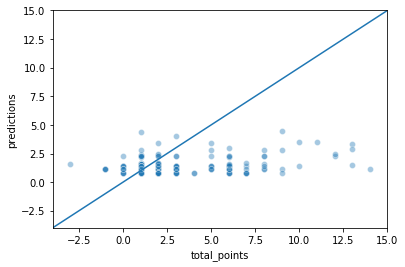

In [61]:
plt.ylim((-4, 15))
plt.xlim((-4, 15))
plt.plot([-4, 15], [-4, 15])

sns.scatterplot(
    comparison['total_points'],
    comparison['predictions'],
    alpha=0.4
)

In [62]:
comparison[['total_points', 'predictions']].sum()

total_points    613.000000
predictions     273.279241
dtype: float64

In [63]:
mean_squared_error(comparison['total_points'], comparison['predictions'])

12.64939519216629